In [43]:
import ipynb.fs.defs.functions as fct
import pandas as pd
import numpy as np
import pickle
import random
from scipy.stats import pearsonr
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

# Sim - refit

In [44]:
all_users_folder = 'data/all_users/'

# Load IDs
with open('uniqueIDs.pkl', 'rb') as f:
    uniqueIDs = pickle.load(f)

In [45]:
# General
model = 'mod10'

# Number of simulations
Nsim = 1

In [46]:
# Model settings
mod_info = pd.read_pickle(all_users_folder + model + '/mod_parameters.pkl')
print(mod_info)

# Extract functions
value_fct = getattr(fct, mod_info['value_fct'])
dec_fct = getattr(fct, mod_info['dec_fct'])

# Parameter bounds
param_lower_bounds = [0, 0, 0, -1]
param_upper_bounds = [1, 1, 6, 1]

{'name': 'model10', 'value_fct': 'rescorla_wagner_2LR_FB_noV0', 'dec_fct': 'my_softmax_shrinking_press_bias', 'param_names': ['alpha_rew', 'alpha_pun', 'beta', 'pi_t']}


In [47]:
def rescorla_wagner_2LR_FB_1trial(vt_m_1, isHit, fb, alpha_rew, alpha_pun):
            
    # if hit, recieves fb
    if isHit == 1:
        
        # Compute prediction error
        pe = fb - vt_m_1

        # Compute new vt and fill in 
        if fb > 0:
            vt = vt_m_1 + alpha_rew * pe
        elif fb < 0:
            vt = vt_m_1 + alpha_pun * pe
        else:
            print('error, fb either 0 or nan?')

    # if no hit, no fb
    elif isHit == 0:
        # vt does not change 
        vt = vt_m_1
        pe = np.nan
        
    return vt, pe

In [48]:
def compute_shrink_factors(trialNo_all_cues, cue):
    
    # Extract trials for this cue
    trials = trialNo_all_cues[cue]

    # Reinitialise each trial of run 2 (above 56)
    trials_per_run_lst = []
    run_size = 56
    for trial in trials:
        if trial > run_size:
            trials_per_run_lst.append(trial-run_size)
        else:
            trials_per_run_lst.append(trial)

    # Convert to array
    trials_per_run = np.array(trials_per_run_lst)

    # Compute shrinking factor = (N-t)/N
    # shrink = (run_size - trials_per_run)/run_size
    shrink = trials_per_run

    return shrink

In [49]:
def get_trials_per_run(trialNo_all_cues, cue):
    
    # Extract trials for this cue
    trials = trialNo_all_cues[cue]

    # Reinitialise each trial of run 2 (above 56)
    trials_per_run_lst = []
    run_size = 56
    for trial in trials:
        if trial > run_size:
            trials_per_run_lst.append(trial-run_size)
        else:
            trials_per_run_lst.append(trial)

    # Convert to array
    trials_per_run = np.array(trials_per_run_lst)

    return trials_per_run

In [50]:
def my_softmax_1trial(beta, vt):

    x = beta * vt
    
    if x > 100:
        p_hit = 1
    else:
        p_hit =  np.exp(x)/(np.exp(x)+1)

    isHit = bernoulli.rvs(p_hit, size=1)

    return int(isHit)

In [51]:
def my_softmax_shrinking_press_bias_1trial(shrink, pi_t, beta, vt):

    # Higher press bias with small trial numbers
    shrinking_pi = pi_t * shrink
    x = beta * (vt + shrinking_pi)
    
    if x > 100:
        p_hit = 1
    else:
        p_hit =  np.exp(x)/(np.exp(x)+1)
    
    isHit = bernoulli.rvs(p_hit, size=1)

    return int(isHit), shrinking_pi

In [52]:
def simulate_behav(fbs_all_cues, trialNo_all_cues, param_values, param_names):
    
    # Value function 
    # Free parameters
    v0 = 0
    alpha_rew = param_values[param_names.index('alpha_rew')]
    alpha_pun = param_values[param_names.index('alpha_pun')]

    # Initialise empty dictionary
    vt_all_cues = dict.fromkeys(fbs_all_cues.keys())
    pe_all_cues = dict.fromkeys(fbs_all_cues.keys())
    shrink_all_cues = dict.fromkeys(fbs_all_cues.keys())
    shrinking_pi_all_cues = dict.fromkeys(fbs_all_cues.keys())
    
    # Decision function
    # Free parameters
    beta = param_values[param_names.index('beta')]
    pi_t = param_values[param_names.index('pi_t')]

    # Initialise empty dictionary
    isHit_all_cues = dict.fromkeys(vt_all_cues.keys())
    
    run_size = 56
    
    # Iterate over cues
    for cue, fbs in zip(fbs_all_cues.keys(), fbs_all_cues.values()):

        # Initialise vector of values
        vts = np.empty(len(fbs))
        vts.fill(np.nan)
        
        # Initialise vector of values
        vtraws = np.empty(len(fbs))
        vtraws.fill(np.nan)

        # Initialise vector of shrinking_pis
        shrinking_pis = np.empty(len(fbs))
        shrinking_pis.fill(np.nan)
        
        # Initialise vector of hits
        hits = np.empty(len(fbs))
        hits.fill(np.nan)

        # Initialise vector of PEs
        pes = np.empty(len(fbs))
        pes.fill(np.nan)
        
        # Fill in prior
        # If want specific prior per cue, check value of cue
        vts[0] = v0
        hits[0] = 0

        # Compute shrink factors for decision function
        shrink = compute_shrink_factors(trialNo_all_cues, cue)

        # Iterate to fill in vector
        for t in range(1,len(vts)):
            vt, pe = rescorla_wagner_2LR_FB_1trial(vts[t-1], hits[t-1], fbs[t-1], alpha_rew, alpha_pun)
            isHit, shrinking_pi = my_softmax_shrinking_press_bias_1trial(shrink[t], pi_t, beta, vt)
            vts[t] = vt
            pes[t] = pe
            hits[t] = isHit
            shrinking_pis[t] = shrinking_pi

        vt_all_cues[cue] = vts
        pe_all_cues[cue] = pes
        isHit_all_cues[cue] = hits
        shrink_all_cues[cue] = shrink
        shrinking_pi_all_cues[cue] = shrinking_pi
        
    return vt_all_cues, pe_all_cues, isHit_all_cues, shrink_all_cues, shrinking_pi_all_cues

In [53]:
# Get parameter values for simulation

# Load fitted parameters
data_mod = pd.read_pickle(all_users_folder + model + '/mod_param_fits.pkl')
parameter_means = data_mod[mod_info['param_names']].mean()
parameter_stds = data_mod[mod_info['param_names']].std()

# Initialise matrices of nans
all_sim_param_values = np.empty((Nsim, len(mod_info['param_names'])))
all_fit_param_values = np.empty((Nsim, len(mod_info['param_names'])))
all_sim_param_values[:] = np.NaN
all_fit_param_values[:] = np.NaN

# Sim and refit
for sim_id in range(0, Nsim):
    
    if sim_id%25==0:
        print(sim_id)
    
    # Sample from mean of fitted values
    params = np.array([])

    for param_mean, param_std, low_b, upp_b in zip(parameter_means, parameter_stds, param_lower_bounds, param_upper_bounds):

        # Sample parameter from mean (resample if not within the bounds)
        param = np.nan
        while not(param >= low_b and param <= upp_b):
            param = np.random.normal(size = 1, loc = param_mean, scale = param_std)

        # Parameter value
        params = np.append(params, param)

    # Store
    mod_info['param_values'] = params

    # Create a model object
    mod = fct.Model(mod_name = mod_info['name'],
                 value_fct = value_fct, 
                 dec_fct = dec_fct, 
                 param_names = mod_info['param_names'])

    # Extract random data set
    random.shuffle(uniqueIDs)
    ID = uniqueIDs[0]
    user_folder = 'data/user_' + ID + '/'
    df2_cf = pd.read_pickle(user_folder + 'df2_cf.pkl')
    _, fbs_all_cues, trialNo_all_cues = fct.extract_hits_fbs(df2_cf)

    # Simulate behaviour
    #mod.simulate_behaviour(fbs_all_cues, trialNo_all_cues, mod_info['param_values'], mod_info['param_names'])
    vt_all_cues, pe_all_cues, isHit_all_cues, shrink_all_cues, shrinking_pi_all_cues = simulate_behav(fbs_all_cues, trialNo_all_cues, mod_info['param_values'], mod_info['param_names'])

    # Input data to model
    mod.gen_param_values = mod_info['param_values']
    mod.set_data('', fbs_all_cues, isHit_all_cues, trialNo_all_cues)    

    # Fit model
    mod.fit(param_lower_bounds, param_upper_bounds, n_iterations=5)

    # Store
    all_sim_param_values[sim_id,:] = mod.gen_param_values
    all_fit_param_values[sim_id,:] = mod.param_values

# Reformat
df_sim = pd.DataFrame(all_sim_param_values, columns = mod_info['param_names'])
df_sim.insert(0, 'Type', 'Sim')
df_sim = df_sim.rename_axis('simID').reset_index()

df_fit = pd.DataFrame(all_fit_param_values, columns = mod_info['param_names'])
df_fit.insert(0, 'Type', 'Fit')
df_fit = df_fit.rename_axis('simID').reset_index()

df = pd.concat([df_sim, df_fit])
df.sort_values(by='simID', ascending=True, inplace = True)
df.reset_index(inplace = True, drop = True)

# Save
df.to_pickle(all_users_folder + '/sim_refit/' + mod_info['name'] + '.pkl')

0


/Volumes/GoogleDrive/Mon Drive/PAT/data_analysis/functions.ipynb:657: RuntimeWarning: overflow encountered in exp
  "                            \n",
/Volumes/GoogleDrive/Mon Drive/PAT/data_analysis/functions.ipynb:657: RuntimeWarning: invalid value encountered in true_divide
  "                            \n",


In [54]:
mod.p_hit['HP']

array([0.49796776, 0.50000018, 0.9860661 , 0.97673903, 0.96207189,
       0.95466526, 0.9287022 , 0.91710767, 0.87494444, 0.885003  ,
       0.99595584, 0.99290809, 0.98782734, 0.97956104, 0.9749503 ,
       0.97495508, 0.96955493, 0.95103083, 0.92335067, 0.99692155,
       0.99454691, 0.99054455, 0.99917719, 0.9984723 , 0.99794386,
       0.99726117, 0.98852157, 0.97274047])

In [55]:
df

,simID,Type,alpha_rew,alpha_pun,beta,pi_t
0,0,Sim,0.395000,0.207822,2.487710,0.290453
1,0,Fit,0.388915,0.034314,2.190398,-0.154824


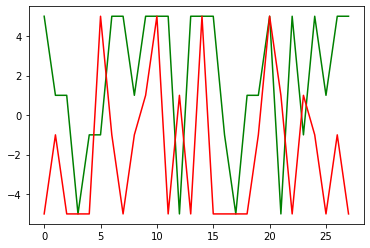

In [39]:
plt.plot(fbs_all_cues['HR'], 'g')
plt.plot(fbs_all_cues['HP'], 'r')
plt.show()

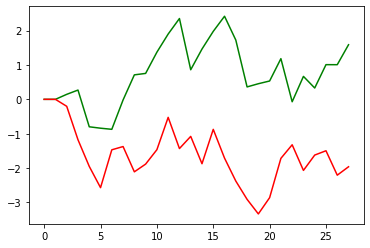

In [40]:
plt.plot(vt_all_cues['HR'], 'g')
plt.plot(vt_all_cues['HP'], 'r')
plt.show()

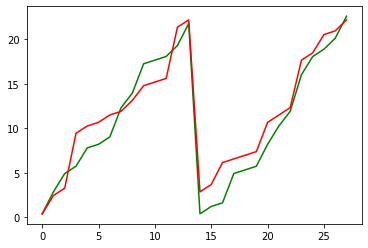

In [41]:
plt.plot(shrinking_pis_all_cues['HR'], 'g')
plt.plot(shrinking_pis_all_cues['HP'], 'r')
plt.show()

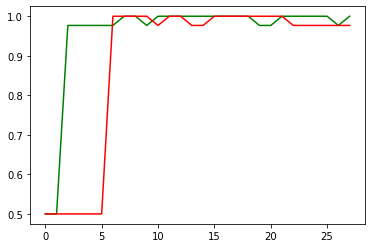

In [42]:
plt.plot(mod.p_hit['HR'], 'g')
plt.plot(mod.p_hit['HP'], 'r')
plt.show()